In [1]:
import pandas as pd
import numpy as np
from numpy import loadtxt
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

#PS: Pressure, bar, 100 Hz --> 100 Messungen pro Sekunde
#EPS: Motor power, W, 100 Hz 
#FS: Volume flow, l/min, 10 Hz --> 10 Messungen pro Sekunde
#TS: Temperature, Celsius, 1 Hz --> 1 Messung pro Sekunde
#VS: Vibration, mm/s, 1Hz
#CE: Cooling efficiency (virtual), %, 1 Hz
#CP: Cooling power (virtual), kW, 1 Hz
#SE: Efficency factor, %, 1 Hz

class DataProcessor:
    def __init__(self, input_path, file_names):
        self.input_path = input_path
        self.file_names = file_names
        
    def read_files(self):
        self.data = {}
        print("Reading files...")
        for file in self.file_names:
            with open(self.input_path + file + '.txt', 'r') as f:
                self.data[file] = loadtxt(f)
        return self.data
    
    def print_shape(self):
        print("Files read:")
        for file in self.data:
            print(f"{file}: {self.data[file].shape}")
            
    def create_target_df(self):
        target_columns = ['Cooler_Condition', 'Valve_Condition', 
                        'Internal_Pump_Leakage', 'Hydraulic_Accumulator', 
                        'Stable_Flag']
        self.df_target = pd.DataFrame(self.data['target'], columns=target_columns)
        self.valve_condition = self.df_target['Valve_Condition']
        del self.data['target']
        return self.valve_condition

def process_data():
    input_path = "input_data/"
    file_names = [
        "ce", "cp", "eps1", "se", "vs1", 
        "fs1", "fs2", 
        "ps1", "ps2", "ps3", "ps4", "ps5", "ps6",
        "ts1", "ts2", "ts3", "ts4", "target"
    ]
    
    processor = DataProcessor(input_path, file_names)
    data = processor.read_files()
    processor.print_shape()
    processor.create_target_df()
    df_target = processor.valve_condition
    return data, df_target

data, df_target = process_data()

Reading files...
Files read:
ce: (2205, 60)
cp: (2205, 60)
eps1: (2205, 6000)
se: (2205, 60)
vs1: (2205, 60)
fs1: (2205, 600)
fs2: (2205, 600)
ps1: (2205, 6000)
ps2: (2205, 6000)
ps3: (2205, 6000)
ps4: (2205, 6000)
ps5: (2205, 6000)
ps6: (2205, 6000)
ts1: (2205, 60)
ts2: (2205, 60)
ts3: (2205, 60)
ts4: (2205, 60)
target: (2205, 5)


Text(0.5, 1.0, 'Originaldaten')

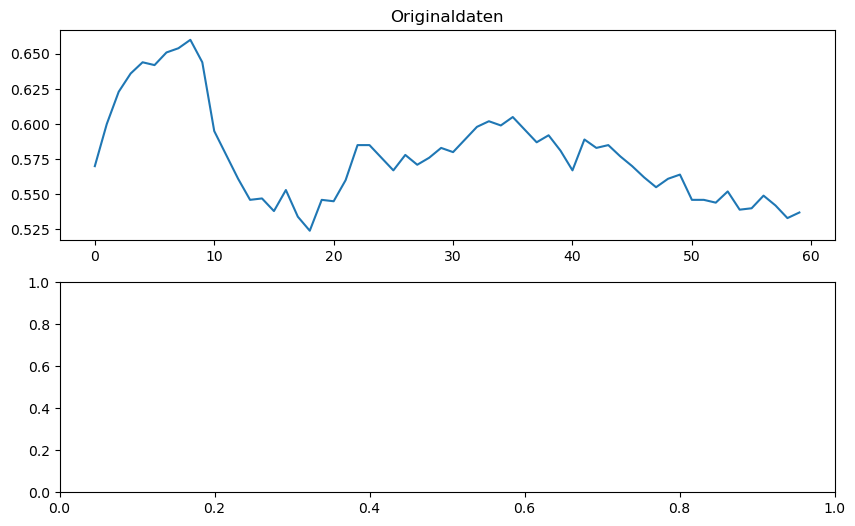

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

# Rohdaten plotten
ax[0].plot(data['vs1'][4], label='Vibration')
ax[0].set_title('Originaldaten')


In [16]:
data['vs1'].shape

(2205, 60)

In [21]:
dfs = {}


input_path = "input_data/"
file_names = [
    "ce", "cp", "eps1", "se", "vs1", 
    "fs1", "fs2", 
    "ps1", "ps2", "ps3", "ps4", "ps5", "ps6",
    "ts1", "ts2", "ts3", "ts4", "target"
]

for file in file_names:
    with open(input_path + file + '.txt', 'r') as f:
        data = pd.read_csv(f, sep="\t", header=None)
        dfs[file] = data

In [26]:
dfs['target'] = dfs['target'][1]

In [ ]:
features = pd.concat([dfs['ce'][0], dfs['cp'][0], dfs['eps1'][0]], axis=1)

In [32]:
data_frames = ["ce", "cp", "eps1", "se", "vs1", 
    "fs1", "fs2", 
    "ps1", "ps2", "ps3", "ps4", "ps5", "ps6",
    "ts1", "ts2", "ts3", "ts4"
]

merge_columns = []

for name in data_frames:
    if name in data_frames:
        first_column = dfs[name].iloc[:, 0]  # Nimm die erste Spalte
        first_column.name = name  # Benenne die Spalte nach dem Dateinamen
        merge_columns.append(first_column) 

In [35]:
merged_df = pd.concat(merge_columns, axis=1)

In [38]:
df_features = merged_df
df_target = dfs['target']

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

  
states = [27, 6728, 49122]
accs = []
features = df_features
target = df_target

for RANDOM_STATE in states:
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size = 0.2, random_state = RANDOM_STATE, stratify = target
    )
    
    model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=50
    )
    
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    accs.append(accuracy_score(y_test, preds))
    print(f"Random State: {RANDOM_STATE}")
    print(classification_report(y_test, preds, zero_division=0.0))

accs_mean = round(np.mean(accs), 4)
accs_std = round(np.std(accs), 4)

print(f"Mean Accuracy: {accs_mean}")
print(f"Std Accuracy: {accs_std}")

c:\Users\Daniel\anaconda3\envs\py_adv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Random State: 27
              precision    recall  f1-score   support

          73       0.35      0.24      0.28        72
          80       0.24      0.22      0.23        72
          90       0.31      0.22      0.26        72
         100       0.65      0.79      0.71       225

    accuracy                           0.51       441
   macro avg       0.39      0.37      0.37       441
weighted avg       0.48      0.51      0.49       441

Random State: 6728
              precision    recall  f1-score   support

          73       0.42      0.29      0.34        72
          80       0.21      0.12      0.16        72
          90       0.30      0.28      0.29        72
         100       0.65      0.82      0.73       225

    accuracy                           0.53       441
   macro avg       0.40      0.38      0.38       441
weighted avg       0.49      0.53      0.50       441



c:\Users\Daniel\anaconda3\envs\py_adv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Daniel\anaconda3\envs\py_adv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Random State: 49122
              precision    recall  f1-score   support

          73       0.20      0.12      0.16        72
          80       0.18      0.12      0.15        72
          90       0.27      0.22      0.24        72
         100       0.63      0.80      0.70       225

    accuracy                           0.48       441
   macro avg       0.32      0.32      0.31       441
weighted avg       0.43      0.48      0.45       441

Mean Accuracy: 0.5087
Std Accuracy: 0.0196
